# Make money in stocks

## Part 4: Stock Selection & Q learning—Stock Selection

Use Markowitz mean-variance method to assign weights to stocks.

### Import packages

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.optimize as sco

### Step 1: Import stock data which can be found on https://finance.yahoo.com.

In [4]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-", regex=True)
sectors=sp500['GICS Sector'].unique()[0:5]
sp50=sp500[sp500['GICS Sector'].isin(sectors)]
sp50=sp50[sp50['Date first added']<'2017-01-01']
sp50=sp50[0:50]
company_symbol=sp50['Symbol'].tolist()
sp50_data=yf.download(tickers=company_symbol,start="2017-10-01",end = '2022-11-26', group_by='ticker')

[*********************100%***********************]  50 of 50 completed


### Step 2: Calculate log-return for each company.

In [5]:
for symbol in company_symbol:
    sp50_data[symbol,'Return']=np.log(sp50_data[symbol]['Close']/sp50_data[symbol]['Close'].shift(1))
sp50_data.head()

ACN                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2017-10-02  135.229996  135.839996  134.619995  135.440002  124.799629   
2017-10-03  134.839996  135.970001  133.660004  134.250000  123.703117   
2017-10-04  134.520004  135.679993  134.460007  135.160004  124.541634   
2017-10-05  135.500000  136.369995  135.270004  136.220001  125.518341   
2017-10-06  136.160004  136.970001  135.720001  136.250000  125.545975   

                           CAH                                   ...  \
             Volume       Open       High        Low      Close  ...   
Date                                                             ...   
2017-10-02  2667500  67.220001  68.389999  67.120003  68.239998  ...   
2017-10-03  2534900  68.250000  68.379997  67.440002  67.599998  ...   
2017-10-04  2193000  67.599998  68.190002  67.339996  67.519997  ...   
2017-10-05  1666100  67.629997  67.930000  67.320000  67.639999  ...   
2017-10-06  1275700  67.599998  67.889999  65.599998  65.879997  ...   

                  CI      CTAS      CSCO       CLX        KO      CTSH  \
              Return    Return    Return    Return    Return    Return   
Date                                                                     
2017-10-02       NaN       NaN       NaN       NaN       NaN       NaN   
2017-10-03  0.015643  0.013319  0.002959  0.002700  0.008668  0.001379   
2017-10-04 -0.006480 -0.001222 -0.012186  0.011183  0.006837  0.001377   
2017-10-05 -0.000367  0.005488  0.004476 -0.017906  0.000439  0.007542   
2017-10-06  0.001415  0.007203  0.004752  0.001395 -0.000659  0.008163   

                  CL     CMCSA       CAG       STZ  
              Return    Return    Return    Return  
Date                                                
2017-10-02       NaN       NaN       NaN       NaN  
2017-10-03 -0.007016  0.008653  0.002097 -0.001355  
2017-10-04  0.006056  0.007543  0.016328  0.010493  
2017-10-05  0.004518 -0.006239  0.004114  0.039330  
2017-10-06 -0.006716 -0.008905 -0.000587  0.004101  

[5 rows x 350 columns]

### Step 3: Construct a data frame about the stocks' daily log-return.

In [6]:
data_return=pd.DataFrame(data=None,columns=company_symbol)
for i in range(50):
    data_return[company_symbol[i]]=sp50_data[company_symbol[i]].loc[:,'Return']
data_return

,MMM,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,A,AKAM,...,CI,CTAS,CSCO,CLX,KO,CTSH,CL,CMCSA,CAG,STZ
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,0.008471,0.001303,-0.007663,-0.008825,0.000946,0.002344,0.004451,0.012635,0.004307,0.009950,...,0.015643,0.013319,0.002959,0.002700,0.008668,0.001379,-0.007016,0.008653,0.002097,-0.001355
2017-10-04,0.009047,0.010917,0.002227,0.006756,-0.013008,0.007230,-0.004384,0.006213,0.010383,0.000000,...,-0.006480,-0.001222,-0.012186,0.011183,0.006837,0.001377,0.006056,0.007543,0.016328,0.010493
2017-10-05,-0.000693,0.010617,0.003110,0.007812,0.007318,0.007409,0.015426,0.019292,-0.001977,0.005529,...,-0.000367,0.005488,0.004476,-0.017906,0.000439,0.007542,0.004518,-0.006239,0.004114,0.039330
2017-10-06,0.000693,0.001456,0.003432,0.000220,0.002533,-0.008107,0.005774,-0.000793,0.009996,-0.002958,...,0.001415,0.007203,0.004752,0.001395,-0.000659,0.008163,-0.006716,-0.008905,-0.000587,0.004101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,-0.003072,0.012692,0.018363,-0.002231,0.003921,0.005797,-0.020847,0.009694,0.012043,0.001761,...,0.022525,0.013645,0.025431,0.006356,0.007058,0.008372,0.015420,0.006981,0.028497,0.011330
2022-11-21,0.006840,0.000096,0.013650,0.001813,0.009402,0.010039,-0.028729,0.006152,-0.007208,-0.000330,...,-0.012356,0.000645,-0.003564,0.017156,0.015258,-0.029959,0.005998,-0.004357,0.012440,0.019078
2022-11-22,0.007571,0.009485,0.016914,0.020245,0.014335,0.016101,0.028789,0.016822,0.077655,0.008870,...,0.012795,0.012509,0.015834,0.011121,0.004340,0.017543,-0.007176,0.021599,0.004933,0.010169


### Step 4: Plot the kernel density to verify the normal distribution.

<AxesSubplot:ylabel='Density'>

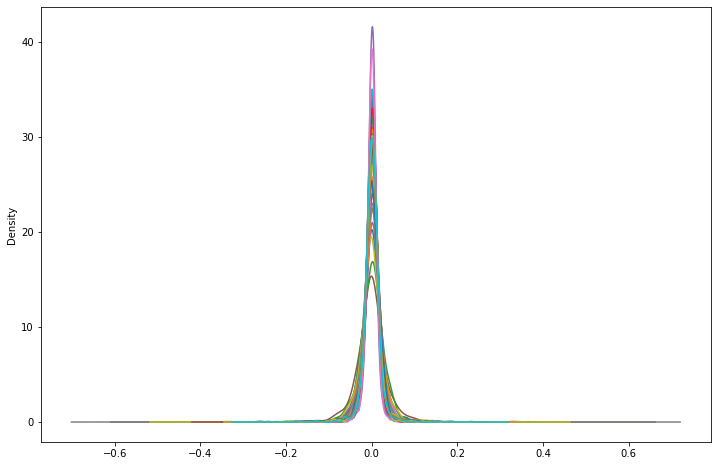

In [7]:
data_return.plot(kind = 'kde',figsize=(12,8),legend=False)

### Step 5: Use Monte Carlo method to generate 2500 weight vectors of 50 companies.

#### Calculate the corresponding returns and risk.

In [8]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(50)
    weights /= np.sum(weights)
    prets.append(np.sum(data_return[data_return.index<'2022-08-27'].mean()*weights)*252)
    pvols.append(np.sqrt(np.dot(
        weights.T,np.dot(data_return[data_return.index<'2022-08-27'].cov()*252,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

#### Set the sharpe ratio as the colorbar value.

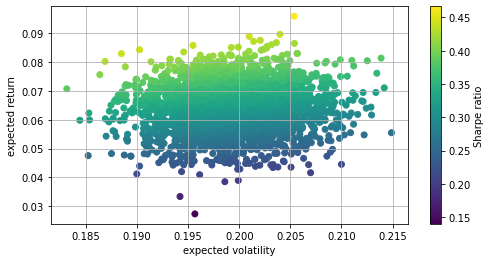

In [14]:
plt.figure(figsize = (8,4))
plt.scatter(pvols,prets,c=prets/pvols,marker = 'o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

 ### Step 6: Define a function to calculate the return, risk and sharpe ratio based on given weights of 50 companies.

In [16]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(data_return[data_return.index<'2022-08-27'].mean() * weights)*252
    pvol = np.sqrt(np.dot(weights.T,
                          np.dot(data_return[data_return.index<'2022-08-27'].cov()*252,weights)))
    return np.array([pret,pvol,pret/pvol])

#### Set the constraint function and bounds.
- The sum of weigths equals to 1
- Set the weight bounds with (0,1).

In [17]:
cons=({'type':'eq','fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(50))

### Step 7: For maximizing the profit.

#### Define the objective function to return the sharpe ratio based on the given weights.

In [18]:
def max_func_sharpe(weights):
    return -statistics(weights)[2]
opts = sco.minimize(max_func_sharpe,50*[1./50],method = 'SLSQP',
                   bounds = bnds, constraints = cons)

#### Select the companies whose weights are non-zero.

In [20]:
ww=list(opts['x'].round(3))
com=list(company_symbol)
see=pd.DataFrame({'com':com,'ww':ww})
see[see['ww']>0]

,com,ww
5,ADM,0.111
21,AAPL,0.528
39,CHD,0.219
41,CTAS,0.142


#### See the return, risk, sharpe ratio of the selected portforlio.

In [21]:
statistics(opts['x'].round(3)).round(3)

array([0.23 , 0.237, 0.968])

### Step 8: For minimizing the profit.

#### Define the objective function to return the sharpe ratio based on the given weights.

In [26]:
def min_func_sharpe(weights):
    return statistics(weights)[2]
mins = sco.minimize(min_func_sharpe,50*[1./50],method = 'SLSQP',
                   bounds = bnds, constraints = cons)

#### Select the companies whose weights are non-zero.

In [27]:
ww1=list(mins['x'].round(3))
com1=list(company_symbol)
see1=pd.DataFrame({'com':com1,'ww':ww1})
see1[see1['ww']>0]

,com,ww
0,MMM,0.271
15,AAL,0.220
23,T,0.401
27,BIIB,0.108


#### See the return, risk, sharpe ratio of the selected portforlio.

In [28]:
statistics(mins['x'].round(3)).round(3)

array([-0.135,  0.256, -0.527])